In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.nn.init as init
from torchvision import datasets

resonance frequency : [700.]
(1, 30000)


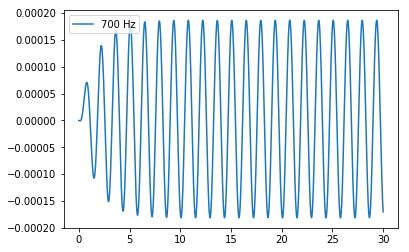

(1, 10000) (1, 20000)


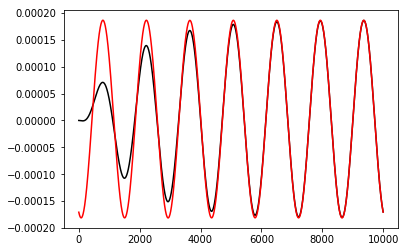

resonance frequency : [450. 700. 950.]
(3, 30000)


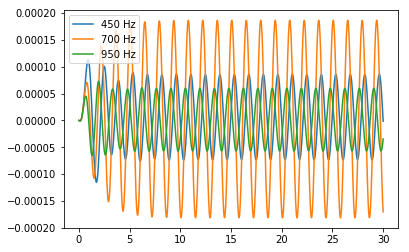

(3, 10000) (3, 20000)


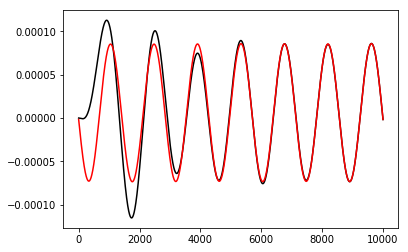

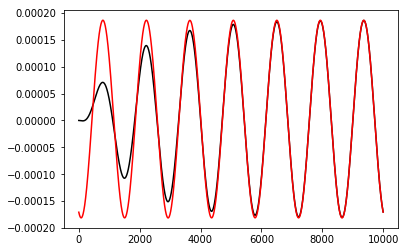

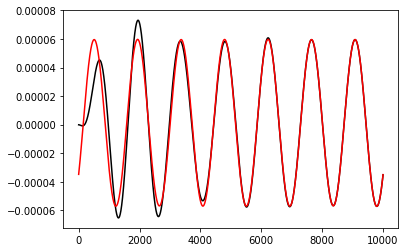

resonance frequency : [ 366.66666667  533.33333333  700.          866.66666667 1033.33333333]
(5, 30000)


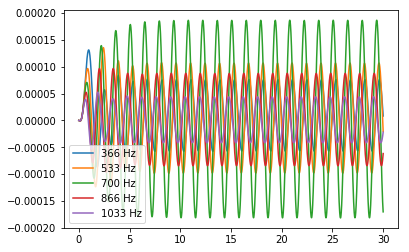

(5, 10000) (5, 20000)


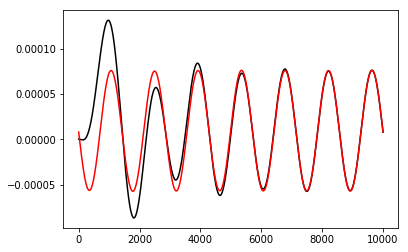

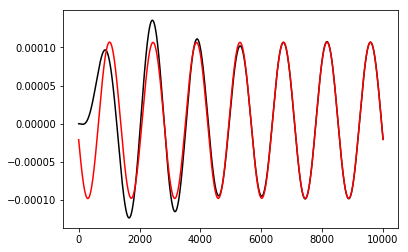

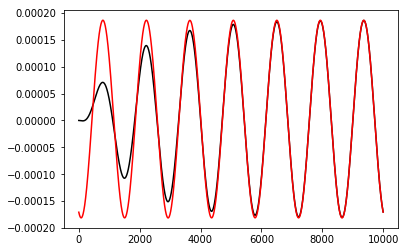

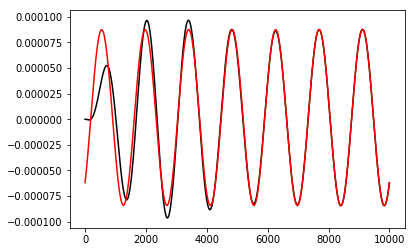

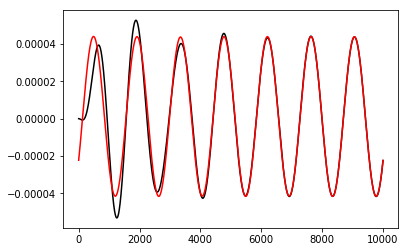

resonance frequency : [ 300.  400.  500.  600.  700.  800.  900. 1000. 1100.]
(9, 30000)


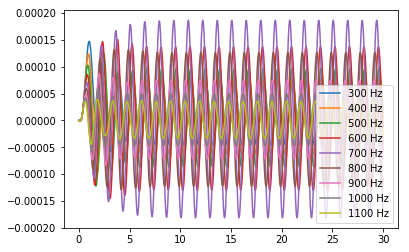

(9, 10000) (9, 20000)


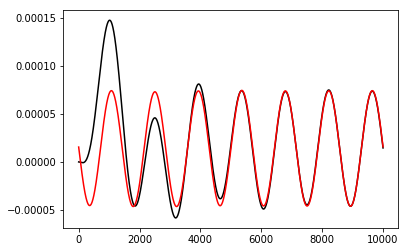

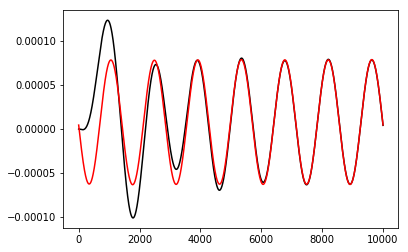

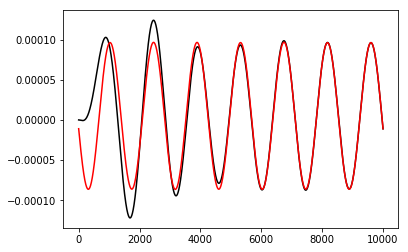

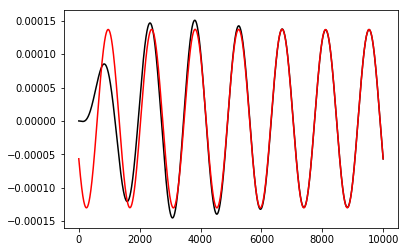

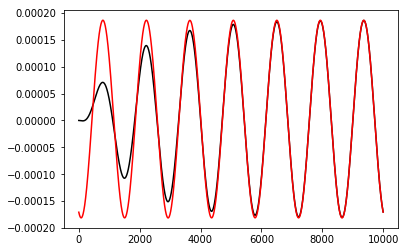

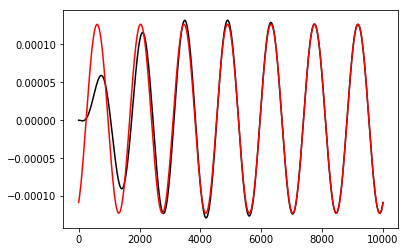

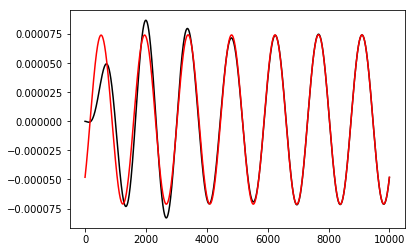

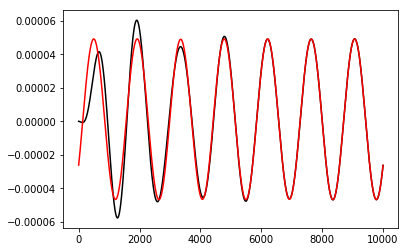

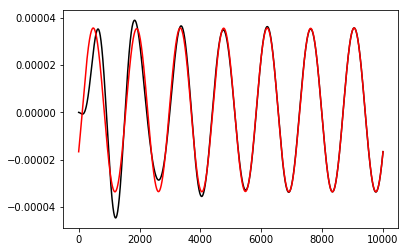

resonance frequency : [ 250.  300.  350.  400.  450.  500.  550.  600.  650.  700.  750.  800.
  850.  900.  950. 1000. 1050. 1100. 1150.]
(19, 30000)


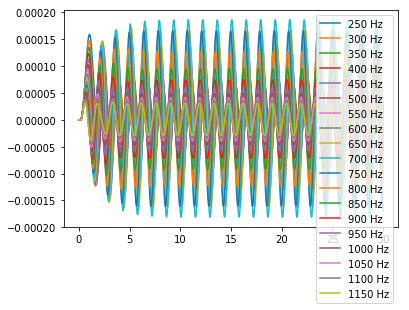

(19, 10000) (19, 20000)


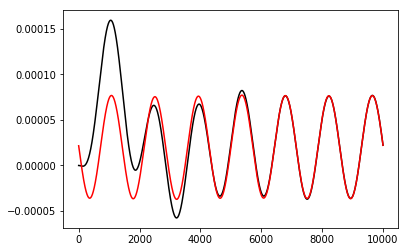

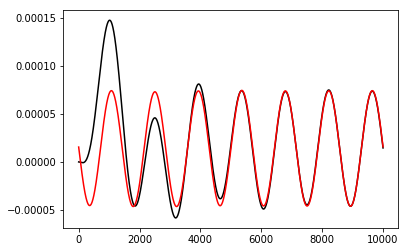

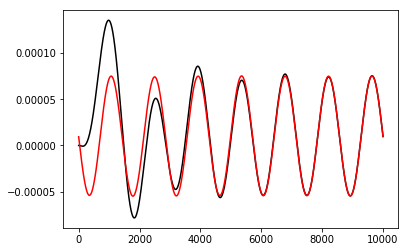

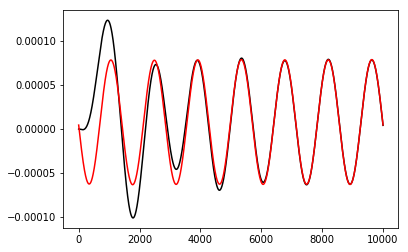

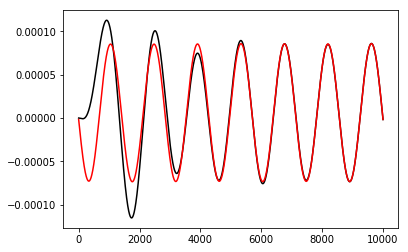

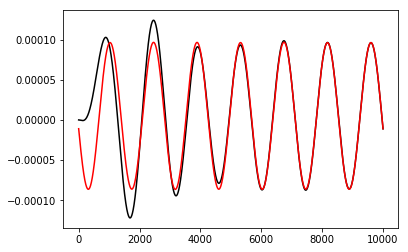

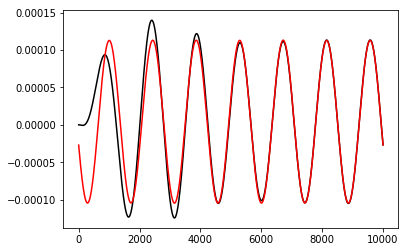

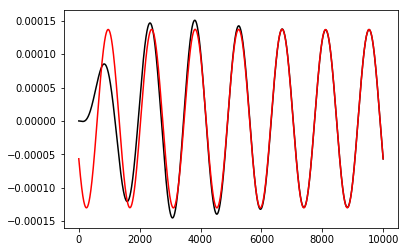

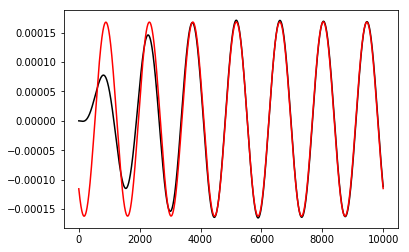

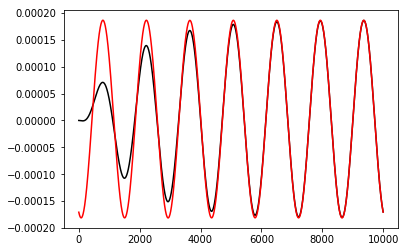

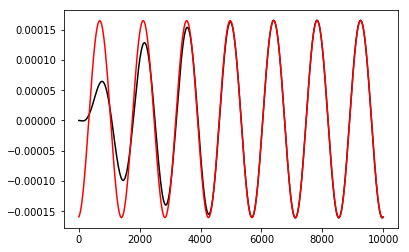

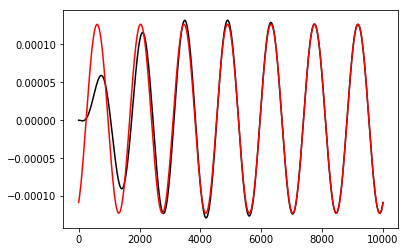

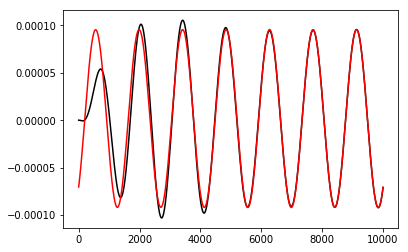

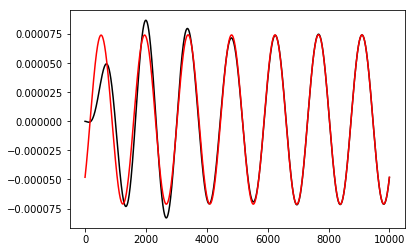

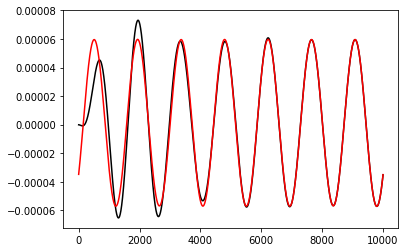

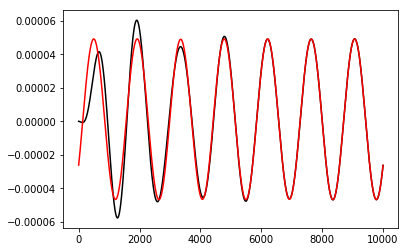

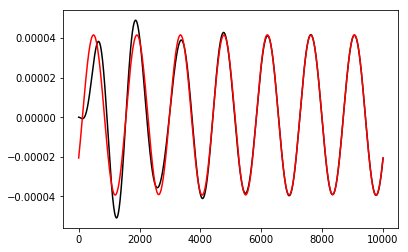

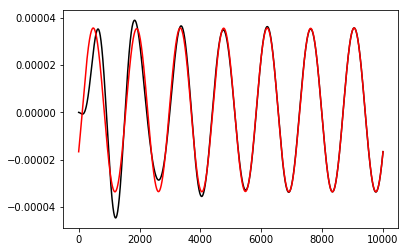

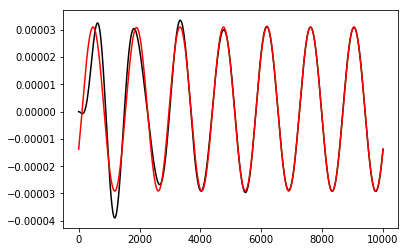

In [10]:
##########data generation

# a =time.time()

ch_list = [1,3,5,9,19]
for c in range(len(ch_list)):
    np.random.seed(37)
    
    time_len = 30     ## ms 
    dt = 1e-6         
    itmax = int((time_len/1000)/dt)
    
    ch_num = ch_list[c]
    w0 = np.linspace(200, 1200,ch_num+2)[1:-1]
    w0 = 2*np.pi*w0
    gm = 200*2*np.pi  ## /s
    mass = 1/w0
    print('resonance frequency :', w0/(2*np.pi))

    col_list = ['k', 'r', 'b', 'y', 'g']    

    freq= 700
    amp = 1000         

    u = np.zeros(ch_num)
    v = np.zeros(ch_num)#+np.random.random()*10
    dudt = np.zeros(ch_num)
    dvdt = np.zeros(ch_num)

    time_list = []

    sound = np.sin(2*np.pi*(freq*np.linspace(0,time_len/1000,itmax)+np.random.random()))
    sound = sound + 0.1*np.random.random(len(sound))
    ##################################################################  
    for it in range(0,itmax):             
        t = it*dt
        dudt = v
        dvdt = -gm*v -(w0**2)*u + amp*sound[it]

        u = u + dudt*dt
        v = v + dvdt*dt

#         if it%20==0:
        time_list.append(t*1000)
        if it==0:
            pos_list = u.reshape(1,-1)
        else:
            pos_list = np.concatenate((pos_list, u.reshape(1,-1)))

    pos_check = np.transpose(pos_list)#[:,::20]
    print(np.shape(pos_check))
    
    for k in range(ch_num):
        label = '%d Hz'%(int(w0[k]/(2*np.pi)+0.1))
        plt.plot(time_list, pos_check[k], label=label)
    plt.legend()
    plt.show()
    
    x = pos_check[:,:10000]
    x_fit = pos_check[:,10000:]
    x_p = np.zeros(np.shape(x))
    print(np.shape(x), (np.shape(x_fit)))
    for c in range(len(x)):
        dis_list = []
        for s in range(5000):
            dis_list.append(np.sum(np.abs(x_fit[c][s:s+10000]-x[c])))
        min_idx = np.argmin(dis_list)
        x_p[c]=x_fit[c][min_idx:min_idx+10000]
        plt.plot(x[c],'k')
        plt.plot(x_p[c],'r')
        plt.show()

    np.save('data/check_xp_fit/%d_X.npy'%ch_num, x)
    np.save('data/check_xp_fit/%d_Y.npy'%ch_num, x_p)

In [3]:
class Model(nn.Module):
    def __init__(self, loss, ch_num):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(ch_num, ch_num, kernel_size=1, stride=1)
        self.loss = loss
        
    def forward(self, data, target):
        x = self.conv1(data)        
        l = self.loss(x, target)
        return l, x, target

def train(model, trainX, trainY, batch, device, optimizer, train_loss):
    model.train()
    dloss = 0
    
    rand = torch.randperm(trainX.size()[0])
    trainX = trainX[rand]
    trainY = trainY[rand]
    
    for i in range(batch[0]):
        optimizer.zero_grad()
        loss, output, target = model(trainX[i*batch[1]:(i+1)*batch[1]], trainY[i*batch[1]:(i+1)*batch[1]])
        loss = loss.sum()
        loss.backward()
        optimizer.step()

        dloss += loss.cpu().item()
        
    train_loss.append(dloss/batch[0])
    return train_loss, output, target

def test(model, testX, testY, batch, device, train_loss, train_acc):
    model.eval()
    dloss = 0
    
    for i in range(batch[0]):
        optimizer.zero_grad()
        loss, output, target = model(trainX[i*batch[1]:(i+1)*batch[1]], trainY[i*batch[1]:(i+1)*batch[1]])
        loss = loss.sum()

        dloss += loss.cpu().item()
        
    test_loss.append(dloss/batch[0])
    return test_loss, output, target

train set : torch.Size([1, 1, 250]) torch.Size([1, 1, 250])
0.283735454082489


/opt/anaconda3/envs/khj/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0.018698107451200485
1.5010457900643814e-05
1.2162002349214163e-05
1.2010998943878803e-05
1.2008349585812539e-05
1.2007518307655118e-05
1.3059029697615188e-05
1.2019952919217758e-05
1.2020879694318864e-05
(1, 1, 250) (1, 1, 250)


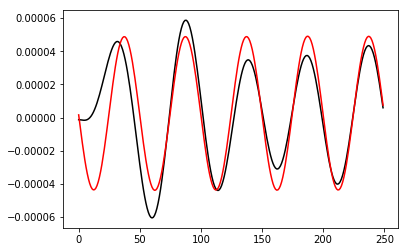

train set : torch.Size([1, 3, 250]) torch.Size([1, 3, 250])
0.34482455253601074
0.09353239834308624
1.7404316167812794e-05
1.2071963283233345e-05
1.1736740816559177e-05
1.2073553989466745e-05
1.1721222108462825e-05
1.1659638403216377e-05
1.2481687917897943e-05
1.1792320947279222e-05
(1, 3, 250) (1, 3, 250)


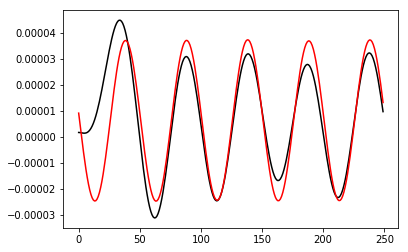

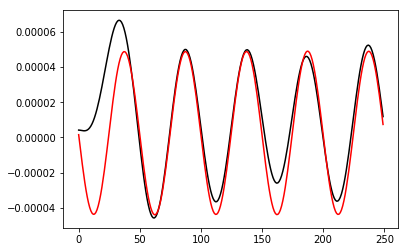

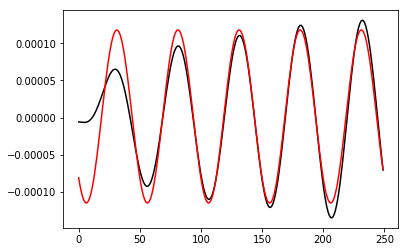

train set : torch.Size([1, 5, 250]) torch.Size([1, 5, 250])
0.10783132165670395
3.358383764862083e-05
1.8408147298032418e-05
1.3246761227492243e-05
9.65505387284793e-06
1.1405712029954884e-05
9.790525837161113e-06
9.642054465075489e-06
9.747825060912874e-06
9.971755389415193e-06
(1, 5, 250) (1, 5, 250)


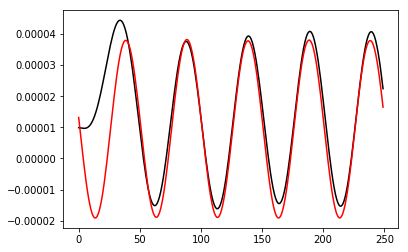

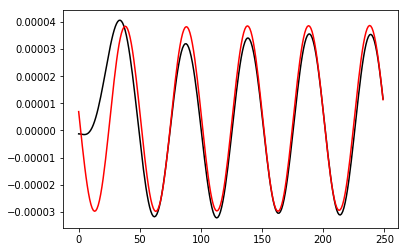

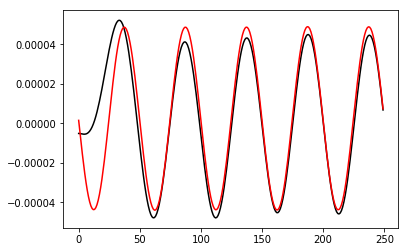

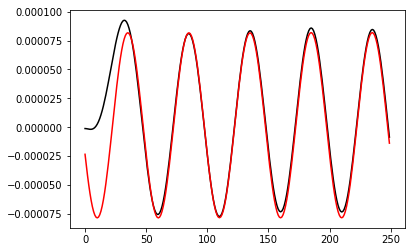

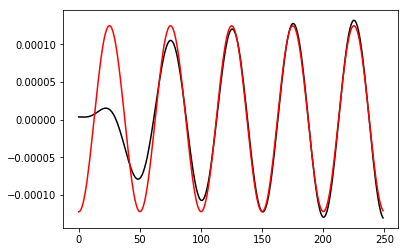

train set : torch.Size([1, 9, 250]) torch.Size([1, 9, 250])
0.227825328707695
0.0073169199749827385
2.557920743129216e-05
1.2758017874148209e-05
9.389438673679251e-06
9.371531632496044e-06
9.670660801930353e-06
9.144202522293199e-06
1.1697004083544016e-05
8.849566256685648e-06
(1, 9, 250) (1, 9, 250)


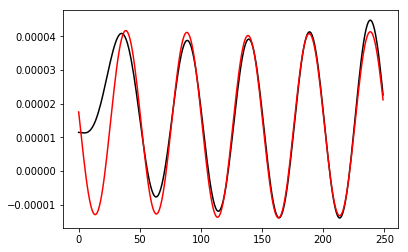

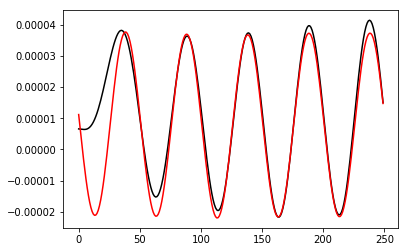

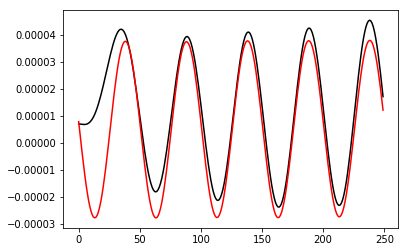

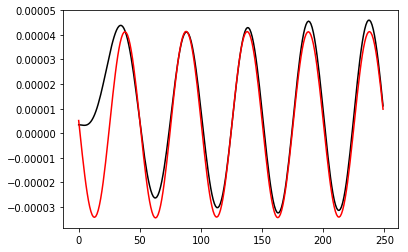

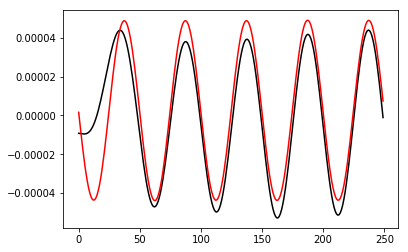

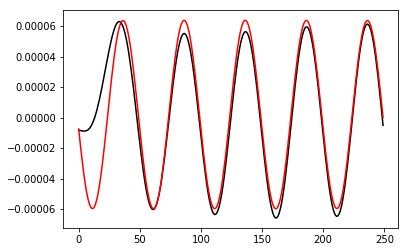

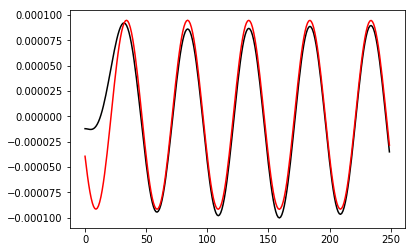

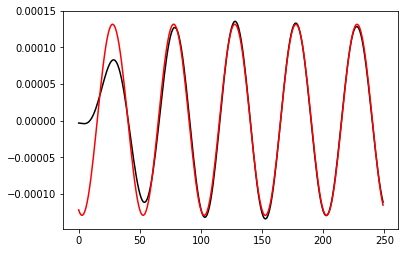

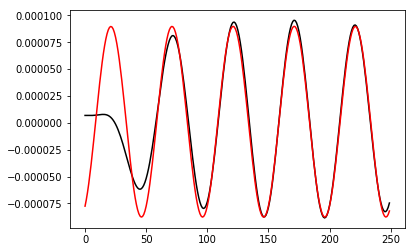

train set : torch.Size([1, 19, 250]) torch.Size([1, 19, 250])
0.10356587916612625
2.6458777938387357e-05
8.463669473712798e-06
9.502965440333355e-06
8.74454235599842e-06
9.59812223300105e-06
9.829425835050642e-06
9.590295121597592e-06
8.297139174828772e-06
9.651774234953336e-06
(1, 19, 250) (1, 19, 250)


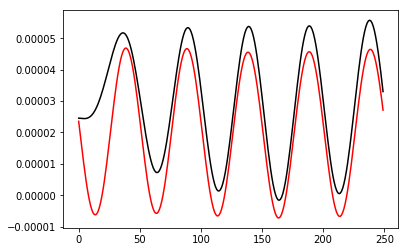

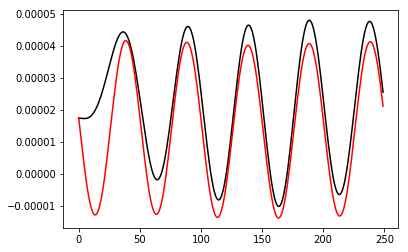

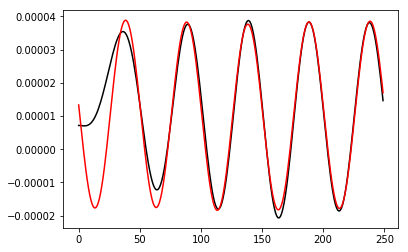

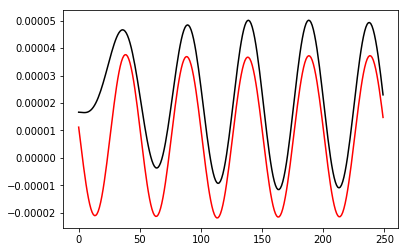

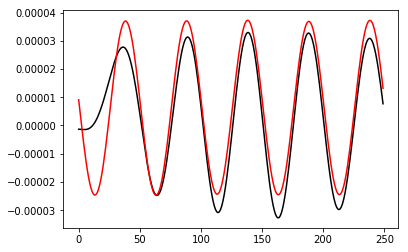

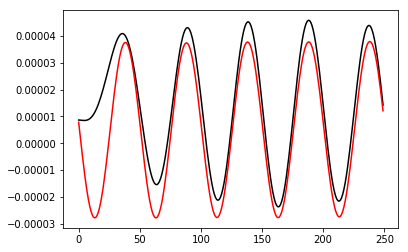

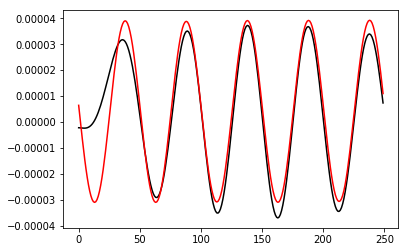

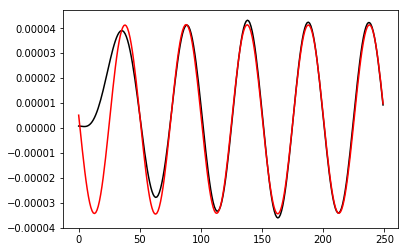

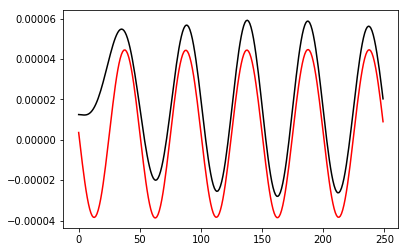

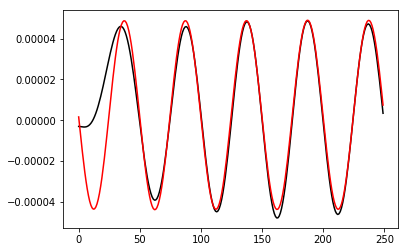

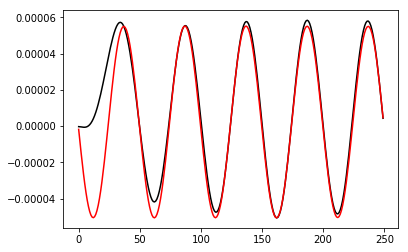

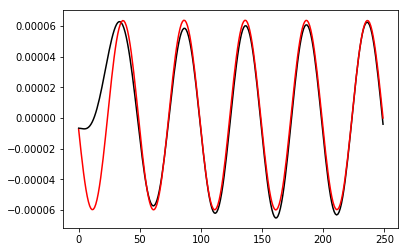

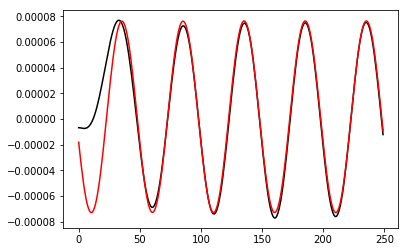

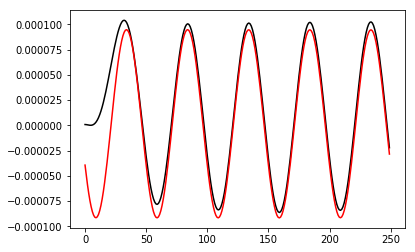

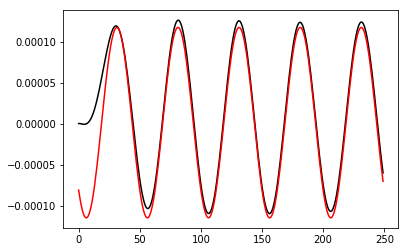

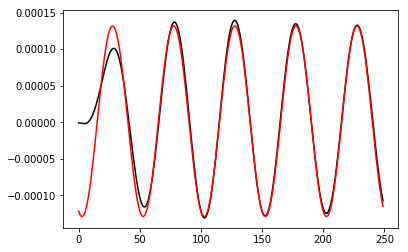

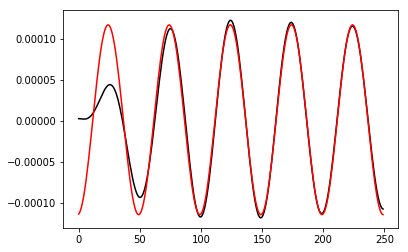

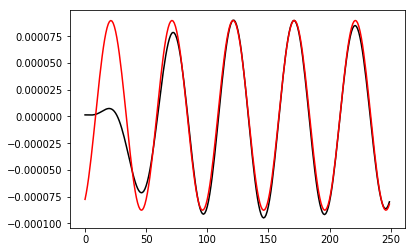

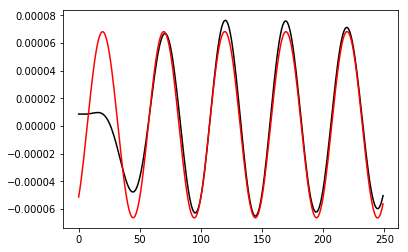

In [4]:
if __name__=='__main__':
    for ccc in ch_list:
        ch_num = ccc
        torch.manual_seed(37)
        torch.cuda.manual_seed_all(37)
        torch.backends.cudnn.deterministic = True

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        trainX = np.load('data/check_xp_fit/%d_X.npy'%ch_num)[:,:5000]
        trainY = np.load('data/check_xp_fit/%d_Y.npy'%ch_num)[:,:5000]
        trainX = trainX.reshape(1,np.shape(trainX)[0],np.shape(trainX)[1])[:,:,::20]
        trainY = trainY.reshape(1,np.shape(trainY)[0],np.shape(trainY)[1])[:,:,::20]

    #     for k in range(len(trainX[0])):
    #         plt.plot(trainX[0][k])
    #         plt.show()

        batch_num = 1#int(len(testX)/2)
        batch = [int(len(trainX)/batch_num), batch_num]
    #     batch_te = [int(len(testX)/batch_num), batch_num]    

        trainX = torch.Tensor(trainX).to(device)
        trainY = torch.Tensor(trainY).to(device)
    #     testX = torch.Tensor(testX).to(device)
    #     testY = torch.Tensor(testY).to(device)
        print('train set :', np.shape(trainX) , np.shape(trainY))
    #     print('test set :', np.shape(testX) ,np.shape(testY))


        learning_rate = 0.00005
        loss_func=nn.L1Loss()
        model = nn.DataParallel(Model(loss_func, ch_num)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=batch_num, eta_min = 3e-6)

        a = time.time()
        train_loss = []
        test_loss = []
        for epoch in range(90001):
            train_loss, output, target = train(model, trainX, trainY, batch, device, optimizer, train_loss)
    #         test_loss = test(model, testX, testY, batch_te, device, test_loss)
            scheduler.step()
        
            if epoch%10000==0: 
                print(train_loss[-1])

        output = output.cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        print(np.shape(output), np.shape(target))
        
        np.savetxt('result/x_p_fit/%dch_loss.txt'%ch_num, train_loss)
        for k in range(len(output[0])):
            plt.plot(output[0][k],'k')
            plt.plot(target[0][k],'r')
            plt.savefig('result/x_p_fit/image/%dch_%d.png'%(ch_num,k+1))
            plt.show()

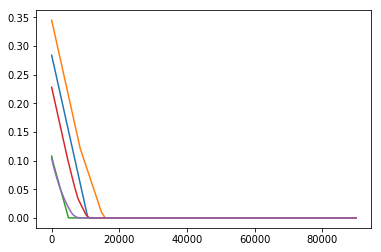

In [6]:
loss_min = []
for k in ch_list:
    a = np.loadtxt('result/x_p_fit/%dch_loss.txt'%k)
    plt.plot(a)
plt.show()